In [1]:
import jax
import jax.numpy as jnp
from opgp import build_solve, build_predict_scalar
import matplotlib.pyplot as plt

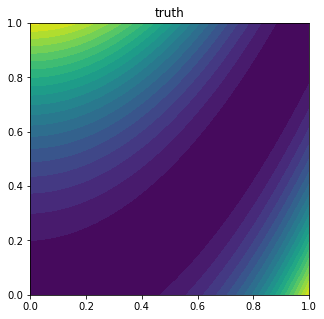

In [2]:
def rosenbrock2d(x, a=1, b=100):
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

f_truth = rosenbrock2d
ngrid = 100
xlims = (0,1)
ylims = (0,1)
xtest = jnp.stack(jnp.meshgrid(jnp.linspace(*xlims, ngrid), jnp.linspace(*ylims, ngrid)), axis=-1).reshape(-1, 2)
ytest = jax.vmap(f_truth)(xtest)
plt.figure(figsize=(5,5))
plt.tricontourf(*xtest.T, ytest, levels=20)
plt.title("truth");

In [3]:
def rbf(x1, x2, lengthscale=1.0):
    return jnp.exp(-0.5 * jnp.sum((x1-x2)**2) / lengthscale**2)

In [4]:
def experiment(k, operators, x=jnp.array([[0.2,0.8], [0.8,0.2]])):
    observations = {key: jax.vmap(op(f_truth))(x) for key, op in operators.items()}
    solve = build_solve(k, operators)
    alphas = solve(x, observations)
    f_sol = build_predict_scalar(k, operators, x, alphas)
    return f_sol

observed $f$ MAE 25.31565820033325 MSE 778.0906901687326
observed $f,\,\nabla f$ MAE 9.429567808327539 MSE 156.68911066367076
observed $f,\,\nabla f,Hess(f)$ MAE 2.685769635113357 MSE 19.36298151993975


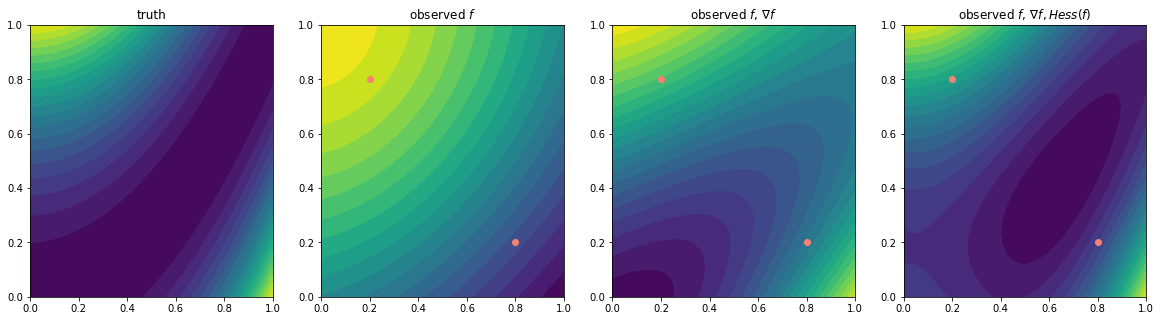

In [5]:
combs = {
    r"observed $f$": {"identity": lambda f: f},
    r"observed $f,\,\nabla f$": {"identity": lambda f: f, "gradient": jax.grad},
    r"observed $f,\,\nabla f,Hess(f)$": {"identity": lambda f: f, "gradient": jax.grad,"hessian": jax.hessian},
#     r"observed $f,Hess(f)$": {"identity": lambda f: f, "hessian": jax.hessian},
#     r"observed $Hess(f)$": {"hessian": jax.hessian},
}
fig, axs = plt.subplots(ncols=1+len(combs), figsize=[5*(1+len(combs)),5])
y_true = jax.vmap(f_truth)(xtest)
axs[0].tricontourf(*xtest.T, y_true, levels=20)
axs[0].set_title("truth")
for ax, (title, comb) in zip(axs[1:], combs.items()):
    # x = jnp.array([[0.2,0.8], [0.8,0.2], [0.8,0.8]])
    x = jnp.array([[0.2,0.8], [0.8,0.2]])
    f_sol = experiment(rbf, comb, x=x)
    y_preds = jax.vmap(f_sol)(xtest)
    mae = jnp.mean(jnp.abs(y_true - y_preds))
    mse = jnp.mean((y_true - y_preds)**2)
    print(title, "MAE", mae, "MSE", mse)
    ax.tricontourf(*xtest.T, y_preds, levels=20)
    ax.scatter(*x.T, c="salmon")
    ax.set_title(title);

# prepare for inkscape

In [6]:
# precompute reconstructions
f = {title: experiment(rbf, comb, x=x) for title, comb in combs.items()}

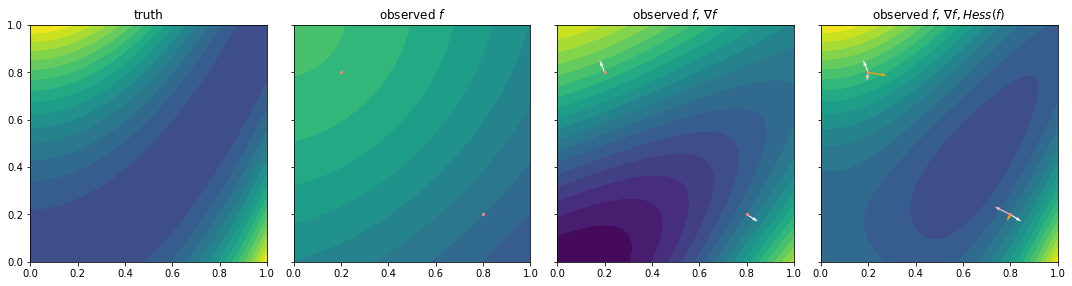

In [7]:
fig, axs = plt.subplots(ncols=1+len(combs), figsize=[5*(len(combs)),5])
levels = jnp.linspace(
    min([jax.vmap(f_truth)(xtest).min()] + [jax.vmap(f_sol)(xtest).min() for _, f_sol in f.items()]),
    max([jax.vmap(f_truth)(xtest).max()] + [jax.vmap(f_sol)(xtest).max() for _, f_sol in f.items()]), 
    num=20
)
axs[0].tricontourf(*xtest.T, jax.vmap(f_truth)(xtest), levels=levels)
axs[0].set_title("truth")
axs[0].set_aspect(1)
for ax, (title, comb) in zip(axs[1:], combs.items()):
    x = jnp.array([[0.2,0.8], [0.8,0.2]])
    f_sol = f[title]
    ax.tricontourf(*xtest.T, jax.vmap(f_sol)(xtest), levels=levels)
    if "hessian" in comb: 
        h = jax.vmap(jax.hessian(f_truth))(x)
        eigvals, eigvecs = jax.vmap(jnp.linalg.eigh)(h)
        λ1, v1 = eigvals[:,0], eigvecs[:,0]
        λ2, v2 = eigvals[:,1], eigvecs[:,1]
        scale = lambda λ, v: v * (jnp.sqrt(jnp.abs(λ)) * jnp.sign(λ))
        scaled1 = jax.vmap(scale)(λ1, v1)
        scaled2 = jax.vmap(scale)(λ2, v2)
        ax.quiver(*x.T, *scaled1.T, width=0.005, color='orange', alpha=0.95)
        ax.quiver(*x.T, *scaled2.T, width=0.005, color='pink', alpha=0.95)
    if "gradient" in comb:
        ax.quiver(*x.T, *jax.vmap(jax.grad(f_truth))(x).T, width=0.005, color='white', alpha=0.95)
    if "identity" in comb:
        ax.scatter(*x.T, c="salmon", s=5)
    ax.set_aspect(1)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_title(title);
plt.tight_layout()

In [8]:
fig.savefig("hessian-twopoints-contourf.pdf")

# Plot layers

In [9]:
f_sol = f['observed $f,\\,\\nabla f,Hess(f)$']

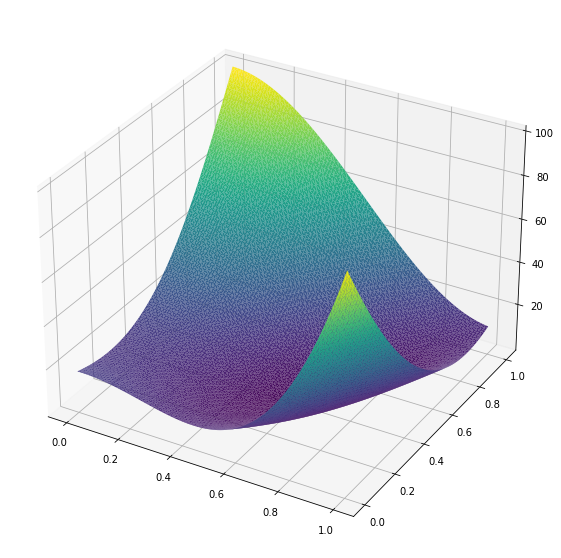

In [10]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,10))
ax.plot_trisurf(*xtest.T, jax.vmap(f_sol)(xtest), cmap=plt.cm.viridis)

In [11]:
fig.savefig("contour3d.pdf")

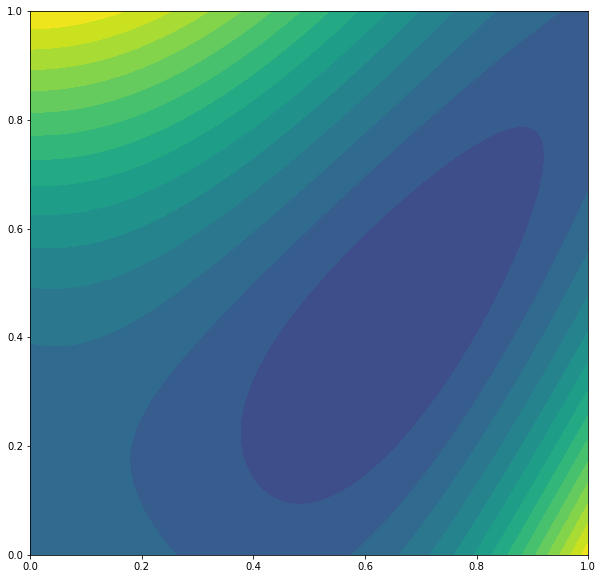

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.tricontourf(*xtest.T, jax.vmap(f_sol)(xtest), levels=levels)
fig.savefig("TOC_countourf.pdf")

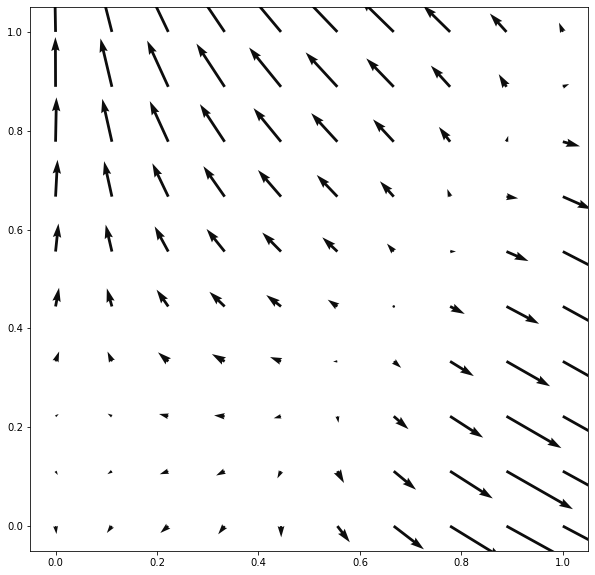

In [13]:
ngrid2 = 10
xtest2 = jnp.stack(jnp.meshgrid(jnp.linspace(*xlims, ngrid2), jnp.linspace(*ylims, ngrid2)), axis=-1).reshape(-1, 2)
fig, ax = plt.subplots(figsize=(10,10))
ax.quiver(*xtest2.T, *jax.vmap(jax.grad(f_sol))(xtest2).T, width=0.005, color='black', alpha=0.95)
fig.savefig("TOC_gradient_quiver.pdf")

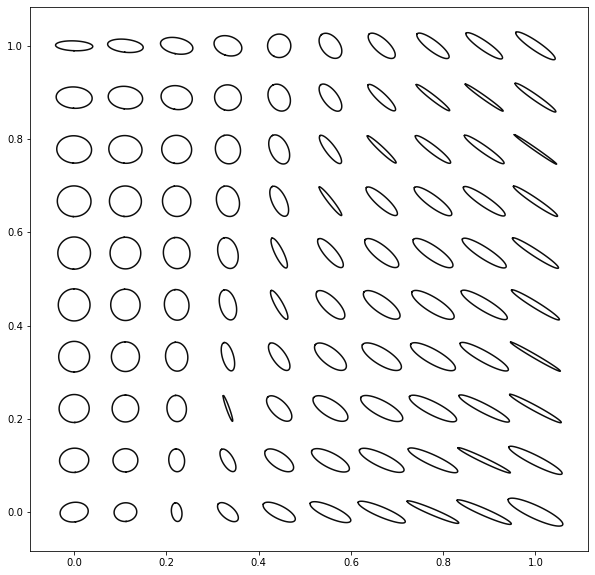

In [14]:
h = jax.vmap(jax.hessian(f_sol))(xtest2)
eigvals, eigvecs = jax.vmap(jnp.linalg.eigh)(h)
λ1, v1 = eigvals[:,0], eigvecs[:,0]
λ2, v2 = eigvals[:,1], eigvecs[:,1]
scale = lambda λ, v: v * (jnp.sqrt(jnp.abs(λ)) * jnp.sign(λ))
scaled1 = jax.vmap(scale)(λ1, v1)
scaled2 = jax.vmap(scale)(λ2, v2)
def ellipse(vec1, vec2):
    theta = jnp.linspace(0, 2*jnp.pi, 100)
    return jax.vmap(lambda t: jnp.sin(t)*vec1 + jnp.cos(t)*vec2)(theta)
ells = jax.vmap(ellipse)(scaled1, scaled2)*0.002
fig, ax = plt.subplots(figsize=(10,10))
# ax.quiver(*xtest2.T, *scaled1.T, width=0.005, color='orange', alpha=0.95)
# ax.quiver(*xtest2.T, *scaled2.T, width=0.005, color='pink', alpha=0.95)
for (xi, ell) in zip(xtest2, ells):
    ell = ell + xi
    ax.plot(*ell.T, color="black", alpha=0.95)
fig.savefig("TOC_hessian_ellipses.pdf")

# Stacked plot

In [15]:

grads = jax.vmap(jax.grad(f_sol))(xtest2)
grads.shape

(100, 2)

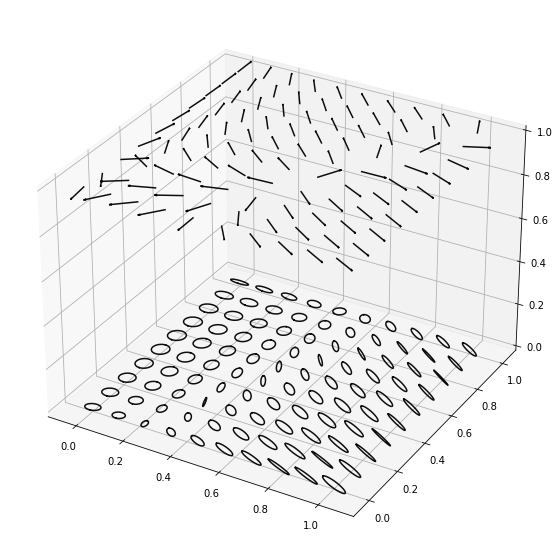

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.quiver(xtest2[:,0], xtest2[:,1], jnp.ones(len(xtest2)), grads[:,0], grads[:,1], jnp.zeros(len(xtest2)), length=0.1, normalize=True, color='black', alpha=0.95, arrow_length_ratio=0.1)
for (xi, ell) in zip(xtest2, ells):
    ell = ell + xi
    ax.plot(*ell.T, zs=0, color="black", alpha=0.95)

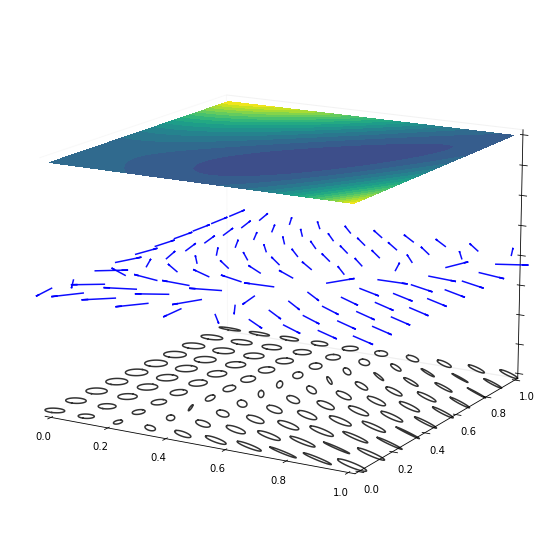

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d',computed_zorder=False)

# plot ellipses
for (xi, ell) in zip(xtest2, ells):
    ell = ell + xi
    ax.plot(*ell.T, zs=0, color="black", alpha=0.80)

# plot grads
ax.quiver(xtest2[:,0], xtest2[:,1], 4*jnp.ones(len(xtest2)), grads[:,0], grads[:,1], jnp.zeros(len(xtest2)), 
    length=0.1, normalize=True, color='blue', alpha=0.95, arrow_length_ratio=0.2, zorder=10)

# plot function values
xgrid = xtest.reshape(ngrid, ngrid, 2)
z = jax.vmap(f_sol)(xtest).reshape(ngrid, ngrid)
ax.contourf(xgrid[:,:,0], xgrid[:,:,1], z, zdir='z', offset=8, levels=levels, zorder=20)

# hide walls
plt.setp(ax.get_zticklabels(), visible=False)
ax.grid(False)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set(xlim=(0,1), ylim=(0,1), zlim=(0,8))
ax.view_init(elev=15.)
fig.savefig("TOC_stack.pdf")